### Imports + load your relationships CSV:

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from pyvis.network import Network
from cdlib import algorithms 

# show plots inline
%matplotlib inline

Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'graph_tool', 'bayanpy', 'infomap'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'infomap'}


In [2]:
df = pd.read_csv("country_relationships_20th_century.csv")
df.head()

,source,target,weight
0,China,Japan,3
1,France,Germany,3
2,France,United Kingdom,3
3,Germany,Russia,2
4,China,North Korea,2


In [3]:
df = df.rename(columns={
    "country_1": "source",
    "country_2": "target"
})

### Creating the NetworkX graph:

In [4]:
if "weight" in df.columns:
    G = nx.from_pandas_edgelist(
        df,
        source="source",
        target="target",
        edge_attr="weight",
        create_using=nx.Graph()
    )
else:
    G = nx.from_pandas_edgelist(
        df,
        source="source",
        target="target",
        create_using=nx.Graph()
    )

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 18
Number of edges: 40


### Static network graph using only NetworkX:

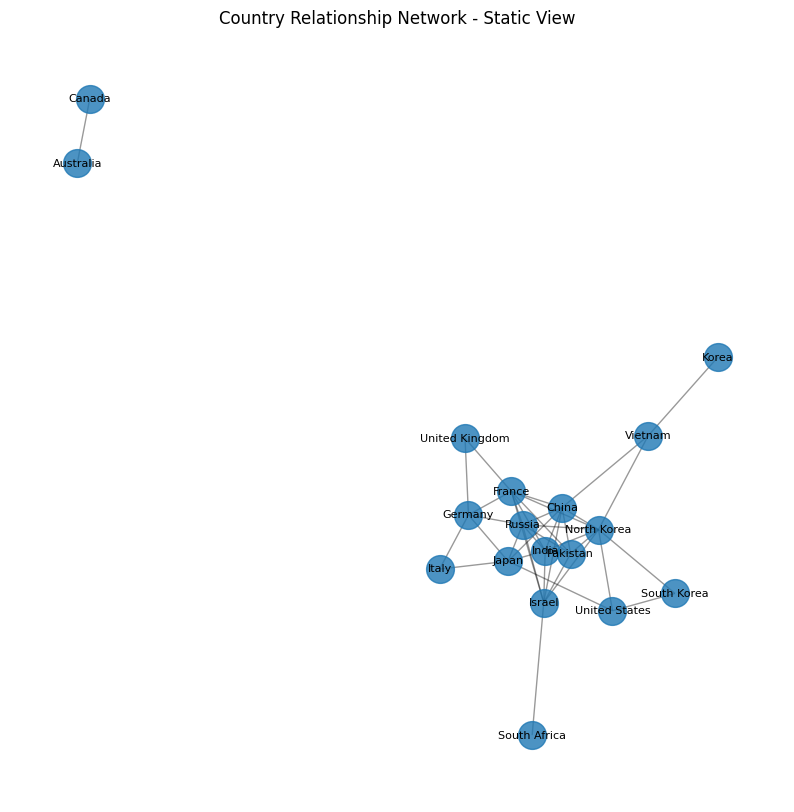

In [5]:
plt.figure(figsize=(10, 10))

pos = nx.spring_layout(G, seed=42)  # layout

nx.draw_networkx_nodes(G, pos, node_size=400, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.4)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Country Relationship Network - Static View")
plt.axis("off")
plt.show()

In [6]:
from pyvis.network import Network

### Interactive graph with Pyvis (HTML):

In [12]:
from pyvis.network import Network

net = Network(
    height="750px",
    width="100%",
    bgcolor="#222222",
    font_color="white",
    notebook=True,
    cdn_resources="in_line"
)

net.from_nx(G)
net.toggle_physics(True)
net.prep_notebook()

html = net.generate_html(notebook=True)

with open("countries_network_basic.html", "w", encoding="utf-8") as f:
    f.write(html)

html

'<html>\n    <head>\n        <meta charset="utf-8">\n        \n            <script>function neighbourhoodHighlight(params) {\n  // console.log("in nieghbourhoodhighlight");\n  allNodes = nodes.get({ returnType: "Object" });\n  // originalNodes = JSON.parse(JSON.stringify(allNodes));\n  // if something is selected:\n  if (params.nodes.length > 0) {\n    highlightActive = true;\n    var i, j;\n    var selectedNode = params.nodes[0];\n    var degrees = 2;\n\n    // mark all nodes as hard to read.\n    for (let nodeId in allNodes) {\n      // nodeColors[nodeId] = allNodes[nodeId].color;\n      allNodes[nodeId].color = "rgba(200,200,200,0.5)";\n      if (allNodes[nodeId].hiddenLabel === undefined) {\n        allNodes[nodeId].hiddenLabel = allNodes[nodeId].label;\n        allNodes[nodeId].label = undefined;\n      }\n    }\n    var connectedNodes = network.getConnectedNodes(selectedNode);\n    var allConnectedNodes = [];\n\n    // get the second degree nodes\n    for (i = 1; i < degrees; i++

### Applying the Leiden algorithm (community detection):

In [13]:
from pyvis.network import Network

net_comm = Network(
    height="750px",
    width="100%",
    bgcolor="#222222",
    font_color="white",
    notebook=True,
    cdn_resources="in_line"
)

for node, data in G.nodes(data=True):
    group = data.get("community", 0)
    net_comm.add_node(
        node,
        label=node,
        group=group,
        title=f"Community: {group}"
    )

for u, v, data in G.edges(data=True):
    w = data.get("weight", "")
    net_comm.add_edge(u, v, title=str(w))

net_comm.toggle_physics(True)
net_comm.prep_notebook()

html_comm = net_comm.generate_html(notebook=True)

with open("countries_network_leiden.html", "w", encoding="utf-8") as f:
    f.write(html_comm)

html_comm 

'<html>\n    <head>\n        <meta charset="utf-8">\n        \n            <script>function neighbourhoodHighlight(params) {\n  // console.log("in nieghbourhoodhighlight");\n  allNodes = nodes.get({ returnType: "Object" });\n  // originalNodes = JSON.parse(JSON.stringify(allNodes));\n  // if something is selected:\n  if (params.nodes.length > 0) {\n    highlightActive = true;\n    var i, j;\n    var selectedNode = params.nodes[0];\n    var degrees = 2;\n\n    // mark all nodes as hard to read.\n    for (let nodeId in allNodes) {\n      // nodeColors[nodeId] = allNodes[nodeId].color;\n      allNodes[nodeId].color = "rgba(200,200,200,0.5)";\n      if (allNodes[nodeId].hiddenLabel === undefined) {\n        allNodes[nodeId].hiddenLabel = allNodes[nodeId].label;\n        allNodes[nodeId].label = undefined;\n      }\n    }\n    var connectedNodes = network.getConnectedNodes(selectedNode);\n    var allConnectedNodes = [];\n\n    // get the second degree nodes\n    for (i = 1; i < degrees; i++

In [14]:
node_to_community = {}
for i, comm in enumerate(communities):
    for node in comm:
        node_to_community[node] = i

nx.set_node_attributes(G, node_to_community, "community")

### Visualize communities in another Pyvis HTML:

In [15]:
net_comm = Network(
    height="750px",
    width="100%",
    bgcolor="#222222",
    font_color="white",
    notebook=False
)

for node, data in G.nodes(data=True):
    group = data.get("community", 0)
    net_comm.add_node(
        node,
        label=node,
        group=group,
        title=f"Community: {group}"
    )

for u, v, data in G.edges(data=True):
   
    w = data.get("weight", "")
    net_comm.add_edge(u, v, title=str(w))

net_comm.toggle_physics(True)
net_comm.show("countries_network_leiden.html")

### Degree, closeness, betweenness centrality:

In [16]:
# Degree centrality
deg_cent = nx.degree_centrality(G)

# Closeness centrality
clo_cent = nx.closeness_centrality(G)

# Betweenness centrality
bet_cent = nx.betweenness_centrality(G, normalized=True)

centrality_df = pd.DataFrame({
    "country": list(G.nodes()),
    "degree_centrality": [deg_cent[n] for n in G.nodes()],
    "closeness_centrality": [clo_cent[n] for n in G.nodes()],
    "betweenness_centrality": [bet_cent[n] for n in G.nodes()],
    "community": [G.nodes[n].get("community") for n in G.nodes()]
})

centrality_df.sort_values("degree_centrality", ascending=False).head(10)

,country,degree_centrality,closeness_centrality,betweenness_centrality,community
6,North Korea,0.529412,0.601604,0.194608,1
0,China,0.470588,0.601604,0.106373,0
2,France,0.470588,0.575448,0.107108,0
5,Russia,0.470588,0.575448,0.050245,0
8,India,0.411765,0.551471,0.016667,0
10,Israel,0.411765,0.529412,0.102941,0
1,Japan,0.352941,0.509050,0.098284,2
9,Pakistan,0.352941,0.509050,0.000000,0
3,Germany,0.294118,0.441176,0.046201,2
15,United States,0.176471,0.441176,0.020221,1


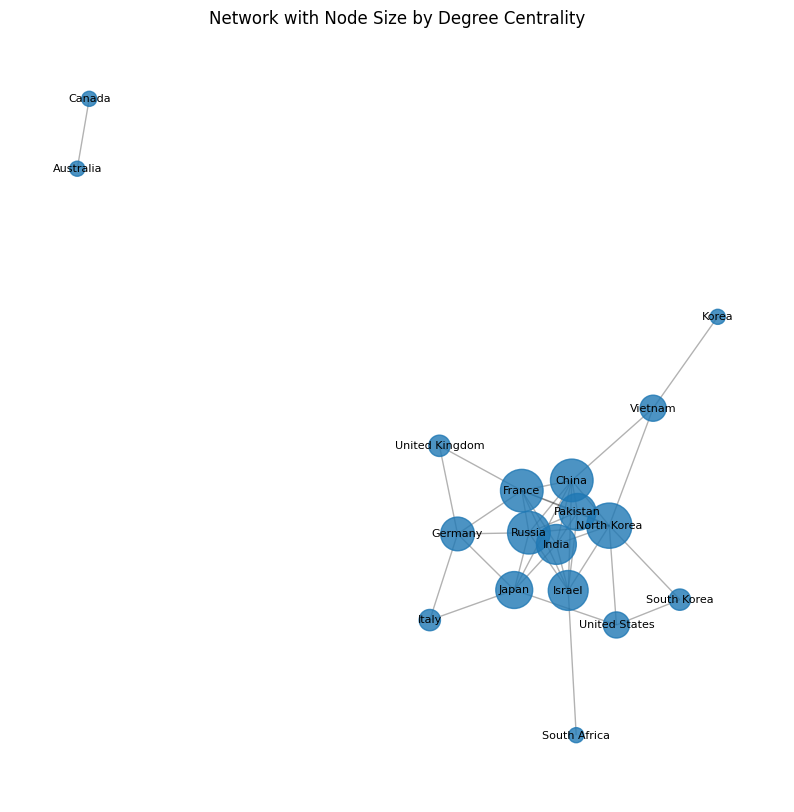

In [17]:
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, seed=42)

node_sizes = [deg_cent[n] * 2000 for n in G.nodes()]  # scale factor

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Network with Node Size by Degree Centrality")
plt.axis("off")
plt.show()

#### Observations for Centralities:

##### Degree centrality:

Which countries have the highest degree?

Do they match major 20th-century powers or key alliance hubs?

##### Closeness centrality:

Countries that can “reach” others quickly (few steps) — often politically central or connected in many contexts.

##### Betweenness centrality:

Countries that act as “bridges” between groups (high betweenness).

Are these historically mediators, strategically located, or influential in alliances?